# Library and Path Setting

In [1]:
# library
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os
import scipy



# load Neural Network Model Library => condition 3 of assignment
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [2]:
# path
train_path = "./cifar10/train/"
test_path = "./cifar10/test/"

## Data Load   
ImageDataGenerator로 데이터를 로드하면서 rescale을 동시에 진행하도록 했습니다.  
원본 데이터셋 디렉토리 구조가 train, test만 존재하여 ImageDataGenerator로 로드하면서 validation_split을 0.1로 주어 동시에 validation data를 분할하도록 했습니다.  
아래 학습부분에서 model.fit_generator를 활용했기에 학습에 대한 하이퍼파라미터인 batch_size는 아래 flow_from_directory 메서드의 파라미터로 조절합니다.

In [3]:
# Set generator with rescaler(1./255) -> condition 2 of assignment
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

# make a loading data flow from path. It generates data at each batch sizes -> condition 1 of assignment
batch_size_num = 100
train_generator = train_datagen.flow_from_directory(train_path,
                                                    classes=sorted(os.listdir(train_path)),
                                                    batch_size = batch_size_num,
                                                    target_size = (256, 256),
                                                    subset="training",
                                                    class_mode='categorical')

valid_generator = train_datagen.flow_from_directory(train_path, 
                                                    classes=sorted(os.listdir(train_path)), 
                                                    batch_size = batch_size_num, 
                                                    target_size=(256, 256), 
                                                    subset="validation",
                                                    class_mode='categorical')


test_generator = test_datagen.flow_from_directory(test_path, 
                                                  classes=sorted(os.listdir(test_path)),
                                                  batch_size = 100,
                                                  target_size = (256, 256),
                                                  class_mode='categorical')

print()
# check shape of data shape
print("check shape of data shape")
for x_data, class_data in train_generator:
    print(f"input data shape from train_generator: {x_data.shape}")
    print(f"class data shape from train_generator: {class_data.shape}")
    break

for x_data, class_data in valid_generator:
    print(f"input data shape from valid_generator: {x_data.shape}")
    print(f"class data shape from valid_generator: {class_data.shape}")
    break
    
for x_data, class_data in test_generator:
    print(f"input data shape from test_generator: {x_data.shape}")
    print(f"class data shape from test_generator: {class_data.shape}")
    break    



Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.

check shape of data shape
input data shape from train_generator: (100, 256, 256, 3)
class data shape from train_generator: (100, 10)
input data shape from valid_generator: (100, 256, 256, 3)
class data shape from valid_generator: (100, 10)
input data shape from test_generator: (100, 256, 256, 3)
class data shape from test_generator: (100, 10)


# Model Architecture  
모델 아키텍쳐는 Image Classification이기에, 기본적인 AlexNet의 구조에서 10개의 class를 classify하도록 변형했습니다.  
또한 Fully Connected Layer에서 Batch Normalization(Batch 형태로 나누어진 데이터를 고려하여 정규화. Local optimum으로 인한 학습속도 저하 및 멈춤을 방지하기 위해 사용), Dropout(뉴런을 부분적으로 생략하여 오버피팅 방지)을 조합하여 사용함으로 학습과정을 보다 효율적으로 만들었습니다.

In [4]:
# set neural model architecture (transform AlexNet architecture)

model = Sequential()

# Convolutional layers
model.add(Conv2D(96, (11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))

model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))

model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())

# Fully-connected layers

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 256)      1024      
 hNormalization)                                                 
                                                        

# Training Step  
fit_generator 메소드를 사용하여 학습했습니다. steps_per_epoch 파라미터의 경우, ImageDatagenerator의 파라미터인 batch_size로 전체 데이터 사이즈를 나누었기에 iteration과 같습니다.  
하이퍼파라미터인 epochs는 여기서 조절합니다.  

이후 Hyper Parameter Optimization은 batch_size => Train data와 Valid data 크기의 공약수 중 3개, epoch => 20, 25, 30을 기준으로 진행했습니다.  
(batch_size, epoch) => (100, 20), (100, 25), (100, 30), (200, 20), (200, 25), (200, 30), (250, 20), (250, 25), (250, 30)

In [5]:
# train with fit_generator method
# steps_per_epoch => same with iterations(train_data_size//batch_size) in model.fit
epochs_num = 30
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//valid_generator.batch_size,
    shuffle=True,
    epochs=epochs_num)

<ipython-input-5-23bd0cc7fb24>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
450/450 [==============================] - 87s 171ms/step - loss: 2.1309 - accuracy: 0.2731 - val_loss: 1.7505 - val_accuracy: 0.3434
Epoch 2/30
450/450 [==============================] - 71s 158ms/step - loss: 1.5234 - accuracy: 0.4376 - val_loss: 2.0123 - val_accuracy: 0.3668
Epoch 3/30
450/450 [==============================] - 75s 167ms/step - loss: 1.3534 - accuracy: 0.5106 - val_loss: 1.3811 - val_accuracy: 0.5022
Epoch 4/30
450/450 [==============================] - 71s 157ms/step - loss: 1.1827 - accuracy: 0.5810 - val_loss: 1.4151 - val_accuracy: 0.5212
Epoch 5/30
450/450 [==============================] - 77s 171ms/step - loss: 1.0240 - accuracy: 0.6400 - val_loss: 1.0687 - val_accuracy: 0.6154
Epoch 6/30
450/450 [==============================] - 72s 159ms/step - loss: 0.9034 - accuracy: 0.6878 - val_loss: 1.0183 - val_accuracy: 0.6434
Epoch 7/30
450/450 [==============================] - 77s 172ms/step - loss: 0.8034 - accuracy: 0.7263 - val_loss: 0.8788 - val_ac

# Plot of Training Result
Accuracy Plot과 Loss Plot을 학습기록에서 불러와 관찰합니다.

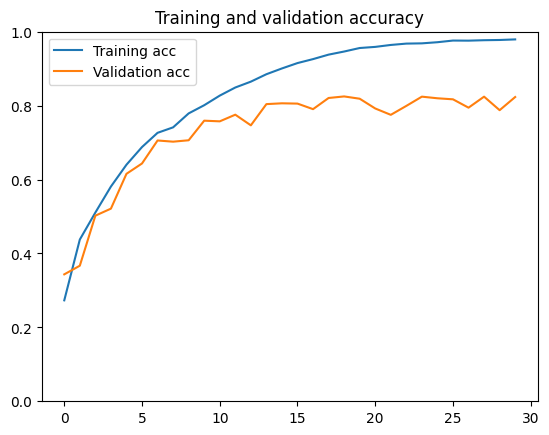

In [6]:
# accuracy plot

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, label="Training acc")
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.ylim(0,1)
plt.savefig(f'./result_plot/batch_{batch_size_num}_epoch_{epochs_num}_acc_plot.png')
plt.show()

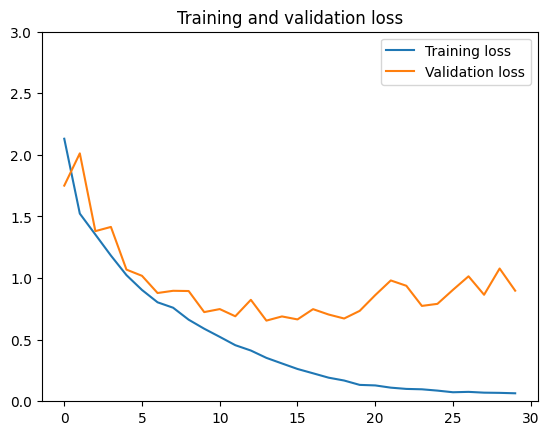

In [7]:
# loss plot
acc = history.history['loss']
val_acc = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, label="Training loss")
plt.plot(epochs, val_acc, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.ylim(0, 3)
plt.savefig(f'./result_plot/batch_{batch_size_num}_epoch_{epochs_num}_loss_plot.png')
plt.show()

# Evaluation  
테스트 데이터에 대해서 학습된 모델의 성능을 확인합니다.

In [8]:
# model evaluation
print("-- Evaluate --")
scores = model.evaluate_generator(test_generator, steps=test_generator.n//test_generator.batch_size)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --


<ipython-input-8-8190f70dd792>:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, steps=test_generator.n//test_generator.batch_size)


accuracy: 81.91%
